# Telecom Churn | Predictive Analytics

**Objective:** Predict when a customer churns

**Background:** There are many variables in this dataset so the most important part of this process is to reduce the number of variables **to avoid overfitting** and **to avoid the curse of dimensionality**.

**Analysis Objective:** After creating, training, cross validating our model, we want our client to be able to **take action on current customers** (ex: sending specific promotional, gratituous offers etc) **to reduce churn rate**.

### Import modules

In [104]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns

In [152]:
churn = 'churn.csv' # import data
df = pd.read_csv(churn)
df = df.iloc[:, 1:]
df = df.drop(['customerID'],axis=1)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,142,2505,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,498,1466,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,436,157,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,266,1400,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,729,925,1


## Normalize Features

In [120]:
# prep for normalizing
X = df.iloc[:,0:19].values
y = df.iloc[:,19].values

# normalize so prediction on features will be on same scale
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)
dfNorm = pd.DataFrame(X_std, index=df.index, columns=df.columns[0:19])

# add target variable to dataframe
dfNorm['churn'] = df['Churn']

# prep X and y arrays
X = dfNorm.iloc[:,0:19].values
y = dfNorm.iloc[:,19].values

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Create Training and Test Data

In [121]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train.shape, y_train.shape, X_test.shape , y_test.shape

((4930, 19), (4930,), (2113, 19), (2113,))

## Create Pipeline Functions

In [108]:
# pipeline funcion
results_test = {}
results_train = {}
def predict_churn(algo_name,X_train,y_train,X_test,y_test,verbose=0):
    algo_name.fit(X_train, y_train)
    Y_pred = algo_name.predict(X_test)
    acc_train = round(algo_name.score(X_train, y_train) * 100, 2)
    acc_val = round(algo_name.score(X_test, y_test) * 100, 2)
    results_test[str(algo_name)[0:str(algo_name).find('(')]] = acc_val
    results_train[str(algo_name)[0:str(algo_name).find('(')]] = acc_train
    if verbose ==0:
        print("acc train: " + str(acc_train))
        print("acc test: "+ str(acc_val))
    else:
        return Y_pred

In [109]:
from sklearn import metrics

# confusion matrix function
def conf_matrix(algo_name,X_test, y_test):
    y_pred = algo_name.predict(X_test)
    forest_cm = metrics.confusion_matrix(y_pred, y_test, [1,0])
    sns.heatmap(forest_cm, annot=True, fmt='.2f',xticklabels = ["1", "0"] , yticklabels = ["1", "0"] )
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(str(algo_name)[0:str(algo_name).find('(')])

## 1. Random Forrest Classifier

acc train: 99.66
acc test: 79.08
             precision    recall  f1-score   support

          0       0.83      0.90      0.86      1560
          1       0.63      0.49      0.55       553

avg / total       0.78      0.79      0.78      2113



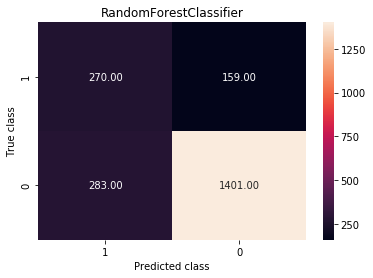

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(n_estimators=50, random_state=0 )
predict_churn(rf,X_train,y_train,X_test,y_test)
print(classification_report(y_test, rf.predict(X_test)))
conf_matrix(rf,X_test, y_test)


## 2. Gradient Boosting Classifier

acc train: 99.61
acc test: 77.38
             precision    recall  f1-score   support

          0       0.83      0.87      0.85      1560
          1       0.58      0.50      0.54       553

avg / total       0.76      0.77      0.77      2113



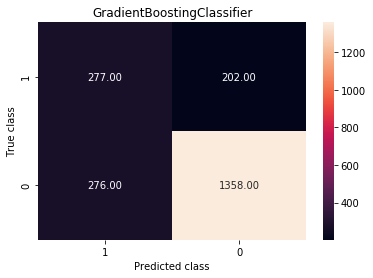

In [111]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(loss='deviance', learning_rate=0.2, n_estimators=200 , max_depth=6)
predict_churn(gbc,X_train,y_train,X_test,y_test)

print(classification_report(y_test, gbc.predict(X_test)))
conf_matrix(gbc,X_test, y_test)

## 3. Support Vector Machine

### 3a. Linear SVM

In [112]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

acc train: 79.98
acc test: 80.03


### 3b. Linear RBF

In [113]:
svm = SVC(kernel='rbf', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

acc train: 82.45
acc test: 79.22


### 3c. Poly SVM

In [114]:
svm = SVC(kernel='poly', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

acc train: 83.45
acc test: 78.89


### Linear SVM Model

acc train: 79.98
acc test: 80.03
             precision    recall  f1-score   support

          0       0.84      0.90      0.87      1560
          1       0.65      0.52      0.58       553

avg / total       0.79      0.80      0.79      2113



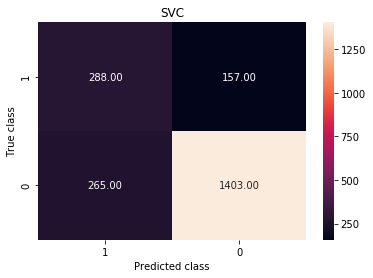

In [122]:
svm = SVC(kernel='linear', probability=True)
predict_churn(svm,X_train,y_train,X_test,y_test)

print(classification_report(y_test, svm.predict(X_test)))
conf_matrix(svm,X_test, y_test)

## 4. K-Nearest Classifier

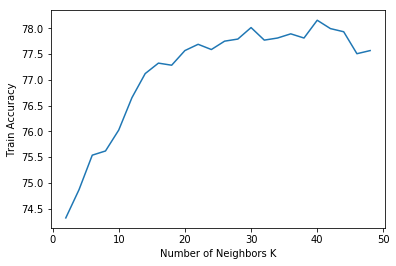

In [116]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

#Neighbors
neighbors = [x for x in list(range(1,50)) if x % 2 == 0]

#Create empty list that will hold cv scores
cv_scores = []

#Perform 10-fold cross validation on training set for odd values of k:
seed=0
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    scores = model_selection.cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    #print("k=%d %0.2f (+/- %0.2f)" % (k_value, scores.mean()*100, scores.std()*100))

optimal_k = neighbors[cv_scores.index(max(cv_scores))]

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

16


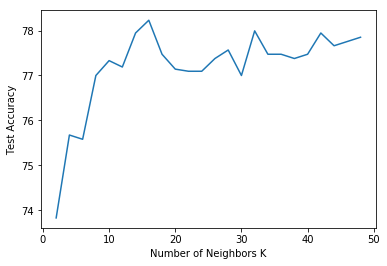

In [117]:
cv_preds = []

#Perform 10-fold cross validation on testing set for odd values of k
seed=0
for k in neighbors:
    k_value = k+1
    knn = KNeighborsClassifier(n_neighbors = k_value, weights='uniform', p=2, metric='euclidean')
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    preds = model_selection.cross_val_predict(knn, X_test, y_test, cv=kfold)
    cv_preds.append(metrics.accuracy_score(y_test, preds)*100)
    #print("k=%d %0.2f" % (k_value, 100*metrics.accuracy_score(test_y, preds)))

optimal_k = neighbors[cv_preds.index(max(cv_preds))]
print(optimal_k)

plt.plot(neighbors, cv_preds)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Test Accuracy')
plt.show()

acc train: 80.69
acc test: 77.99
             precision    recall  f1-score   support

          0       0.82      0.90      0.86      1560
          1       0.61      0.45      0.52       553

avg / total       0.77      0.78      0.77      2113



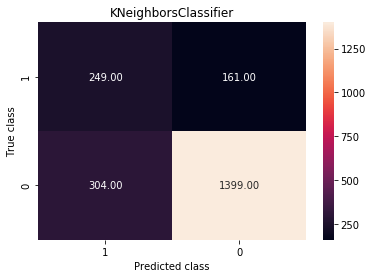

In [118]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 16)
predict_churn(knn,X_train,y_train,X_test,y_test)

print(classification_report(y_test, knn.predict(X_test)))
conf_matrix(knn,X_test, y_test)

## Compare Models

In [123]:
df_test =pd.DataFrame(list(results_test.items()),
                      columns=['algo_name','acc_test'])
df_train =pd.DataFrame(list(results_train.items()),
                      columns=['algo_name','acc_train'])
df_results = df_test.join(df_train.set_index('algo_name'), on='algo_name')
df_results.sort_values('acc_test',ascending=False)

,algo_name,acc_test,acc_train
2,SVC,80.03,79.98
0,RandomForestClassifier,79.08,99.66
3,KNeighborsClassifier,77.99,80.69
1,GradientBoostingClassifier,77.38,99.61


## Feature Importance

In [153]:
df = df.drop(['Churn'], axis=1)

In [154]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [139]:
svm.coef_

array([[-0.00546347,  0.06802181, -0.03176554, -0.00091335, -0.80128115,
        -0.31280051, -0.05676803,  0.34771321, -0.22911499, -0.00538807,
        -0.12400577, -0.26404252, -0.05279909, -0.02882873, -0.08331949,
         0.1282574 ,  0.02438099,  0.8375623 ,  0.0348776 ]])

## Model Explanation

The most effective model out of the 6 algorithms is the **Linear SVM**. What the Linear SVM outputs is a hyperplane that **separates the classes**. The **coefficients above represents the hyperplane** which gives the coordinates of respective vectors that are **orthogonal** to this hyperplane.

The vectors gives the **predicted class** and if you take the **dot product of any point with the vector, you will be able to see which side it belongs w/ respect to the hyperplane** --- positive and negative classes w/ respect to the sign.

Lastly, the **absolute size of the coefficients** relative to the other coefficients give a relative indication of the **importance of the feature for the separation by the hyper plane.**


## Conclusion

With that said, **Monthly Charges, Tenure, Internet and Phone services** are variables to focus for this Telecom company. 

Customers **who are paying a lot** may want to switch to another company for their services. With that said, there may be **promotional offers and discounts** that may help with luring and convincing customers to stay a bit longer.

Furthermore, customers who have been **loyal for quite sometime** may not need to be a significant focus for this Telecom company. The **energy and effort may be best optimized** on those who have just started using the services provided. Give more reasons for them to stay and once they are hooked, you have maximized your potential.

Lastly, Internet and Phone services **may be more of a focus to improve** even though it was not relatively as important as the factors above.